<a href="https://colab.research.google.com/github/arifmohammad1/DecipheringSpeech/blob/main/Copy_of_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
import os # to deal with files
import cv2 # preprocess
import tensorflow as tf # to build pipeline
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=d2aa41e4-dd12-4f83-b9e2-fdd056129938
To: /content/data.zip
100%|██████████| 423M/423M [00:05<00:00, 81.7MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
#Load data from path
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []

    #convert to grayscale and slice mouth portion
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()
char_to_num(['a','r','i','f'])
num_to_char([1,  2,  3, 4])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'b', b'c', b'd'], dtype=object)>

In [ ]:
#loading and reading data
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
def load_data_by_path(path: str):
    path = bytes.decode(path.numpy())
# file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    if '\\' in path:
        file_name = path.split('\\')[-1].split('.')[0]
    else:
        file_name = path.split('/')[-1].split('.')[0]
    # Moved the following two lines outside the if block to ensure they are assigned in all cases
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

tf.Tensor(b'.\\data\\s1\\bbal6n.mpg', shape=(), dtype=string)


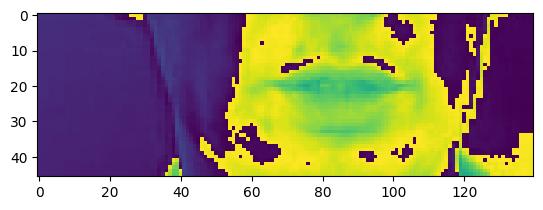

In [ ]:
test_path = r'.\data\s1\bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
test_path_tensor = tf.convert_to_tensor(test_path)

# Print the tensor
print(test_path_tensor)

# Load data using the tensor
frames, alignments = load_data_by_path(test_path_tensor)



plt.imshow(frames[30])


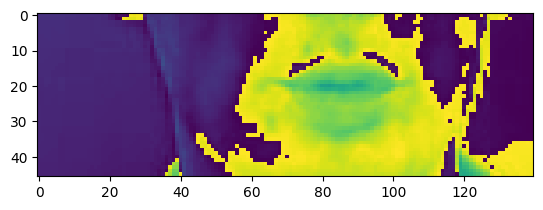

In [ ]:
plt.imshow(frames[25])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

DATA PIPELINE

In [ ]:
from matplotlib import pyplot as plt


data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(420)
test = data.skip(420)


frames, alignments = data.as_numpy_iterator().next()
alignments

array([[16, 12,  1,  3,  5, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39, 17,
        39,  6, 15, 21, 18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39, 18,  5,  4, 39,  2, 25, 39,  5, 39, 14,  9, 14,
         5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
test = data.as_numpy_iterator()
val = test.next(); val[0]

array([[[[[ 1.4705501 ],
          [ 1.4705501 ],
          [ 1.391061  ],
          ...,
          [ 0.23846759],
          [ 9.975894  ],
          [ 9.41947   ]],

         [[ 1.4705501 ],
          [ 1.4705501 ],
          [ 1.391061  ],
          ...,
          [ 9.777171  ],
          [ 9.459214  ],
          [ 9.578448  ]],

         [[ 1.4308056 ],
          [ 1.4308056 ],
          [ 1.4308056 ],
          ...,
          [ 9.697681  ],
          [ 0.        ],
          [10.134872  ]],

         ...,

         [[ 0.95387036],
          [ 0.95387036],
          [ 0.95387036],
          ...,
          [ 0.0397446 ],
          [ 0.0397446 ],
          [ 0.0397446 ]],

         [[ 0.95387036],
          [ 0.95387036],
          [ 0.95387036],
          ...,
          [ 0.07948919],
          [ 0.0397446 ],
          [ 0.0397446 ]],

         [[ 0.95387036],
          [ 0.95387036],
          [ 0.95387036],
          ...,
          [ 0.07948919],
          [ 0.0397446 ],
          

In [ ]:
print(val[0][1].shape)
print(val[0][1][:5])  # Print the first 5 values

(75, 46, 140, 1)
[[[[1.5349807 ]
   [1.4601035 ]
   [1.3103493 ]
   ...
   [0.37438554]
   [0.29950842]
   [0.29950842]]

  [[1.684735  ]
   [1.5349807 ]
   [1.3852265 ]
   ...
   [0.37438554]
   [0.29950842]
   [0.29950842]]

  [[1.422665  ]
   [1.422665  ]
   [1.422665  ]
   ...
   [0.33694696]
   [0.29950842]
   [0.29950842]]

  ...

  [[1.085718  ]
   [1.0108409 ]
   [1.0108409 ]
   ...
   [0.11231566]
   [0.11231566]
   [0.11231566]]

  [[1.0108409 ]
   [1.0108409 ]
   [1.0108409 ]
   ...
   [0.07487711]
   [0.07487711]
   [0.07487711]]

  [[1.0108409 ]
   [1.0108409 ]
   [1.0108409 ]
   ...
   [0.03743855]
   [0.03743855]
   [0.03743855]]]


 [[[1.5724193 ]
   [1.5349807 ]
   [1.3477879 ]
   ...
   [0.37438554]
   [0.29950842]
   [0.29950842]]

  [[1.5724193 ]
   [1.5349807 ]
   [1.4601035 ]
   ...
   [0.37438554]
   [0.29950842]
   [0.29950842]]

  [[1.4975421 ]
   [1.4975421 ]
   [1.4975421 ]
   ...
   [0.33694696]
   [0.33694696]
   [0.33694696]]

  ...

  [[1.0108409 ]
   [1.

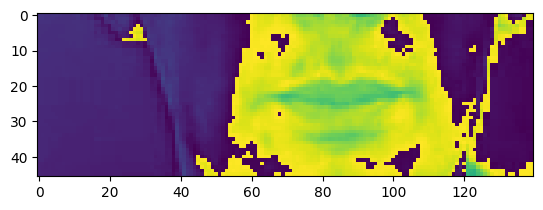

In [ ]:
plt.imshow(val[0][0][15])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue in o six please'>

**Design the neural network**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
yhat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])
model.input_shape
model.output_shape

1/1 [==============================] - 5s 5s/step


(None, 75, 41)

**Setting up learning**

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)


In [ ]:
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(data)
# Assuming your model has already been defined and compiled

# 1. Train the model with callbacks
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 2. Evaluate the model on the test data
loss, accuracy = model.evaluate(test)

print(f'Test accuracy: {accuracy * 100:.2f}%')


 92/420 [=====>........................] - ETA: 5:18:26 - loss: 108.8082

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        # Convert the dataset to a list to be able to iterate over it multiple times
        self.dataset = list(dataset.as_numpy_iterator())

    def on_epoch_end(self, epoch, logs=None) -> None:
        # Iterate over a sample of the data instead of consuming the entire dataset
        for data in self.dataset[:10]:  # Adjust the number of samples as needed
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
            for x in range(len(yhat)):
                print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
                print('~'*100)

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')


Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=73bdfe9f-8a60-4db7-9dec-345d307f8bb1
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 57.1MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:

from tensorflow.keras.optimizers.legacy import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

model.load_weights('models/checkpoint')

In [ ]:
test_data = test

while True:
    try:
        sample = next(test_data)
        yhat = model.predict(sample[0])

        print('~'*100, 'REAL TEXT')
        [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

    except StopIteration:
        print("End of dataset reached.")
        break

End of dataset reached.


In [ ]:
decoded, log_prob = tf.keras.backend.ctc_decode(yhat, input_length=[yhat.shape[1]] * yhat.shape[0], greedy=True) # Replicate the sequence length for each sample in the batch
decoded = decoded[0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'!'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'!'>]

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [ ]:
!ls ./data/s1

bbaf2n.mpg  bram2n.mpg	lbax8n.mpg  lrbe6n.mpg	pbbc4n.mpg  prax1a.mpg	sbat6n.mpg  srao1a.mpg
bbaf3s.mpg  bram3s.mpg	lbax9s.mpg  lrbe7s.mpg	pbbc5s.mpg  praxzp.mpg	sbat7s.mpg  sraozp.mpg
bbaf4p.mpg  bram4p.mpg	lbay1a.mpg  lrbe8p.mpg	pbbc6p.mpg  prbd1s.mpg	sbat8p.mpg  srau2n.mpg
bbaf5a.mpg  bram5a.mpg	lbayzp.mpg  lrbe9a.mpg	pbbc7a.mpg  prbd2p.mpg	sbat9a.mpg  srau3s.mpg
bbal6n.mpg  bras6n.mpg	lbbe1s.mpg  lrbl1s.mpg	pbbi8n.mpg  prbd3a.mpg	sbba8n.mpg  srau4p.mpg
bbal7s.mpg  bras7s.mpg	lbbe2p.mpg  lrbl2p.mpg	pbbi9s.mpg  prbdzn.mpg	sbba9s.mpg  srau5a.mpg
bbal8p.mpg  bras8p.mpg	lbbe3a.mpg  lrbl3a.mpg	pbbj1a.mpg  prbj4n.mpg	sbbb1a.mpg  srbb4n.mpg
bbal9a.mpg  bras9a.mpg	lbbezn.mpg  lrblzn.mpg	pbbjzp.mpg  prbj5s.mpg	sbbbzp.mpg  srbb5s.mpg
bbas1s.mpg  brba1a.mpg	lbbk4n.mpg  lrbr4n.mpg	pbbp2n.mpg  prbj6p.mpg	sbbh2n.mpg  srbb6p.mpg
bbas2p.mpg  brbazp.mpg	lbbk5s.mpg  lrbr5s.mpg	pbbp3s.mpg  prbj7a.mpg	sbbh3s.mpg  srbb7a.mpg
bbas3a.mpg  brbg2n.mpg	lbbk6p.mpg  lrbr6p.mpg	pbbp4p.mpg  prbp8n.mpg	sbbh4p.mpg 

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/lip_read.h5',compile=False)

In [ ]:
import os

file_path = './data/s1/bbizzn.mpg'

if os.path.exists(file_path):
    sample = load_data(tf.convert_to_tensor(file_path))
else:
    print(f"Error: File not found at {file_path}")

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 183ms/step


In [ ]:
model.save('lip_read.h5')

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in z zero now'>]

In [ ]:
print("Shape of sample[1]:", sample[1].shape)
print("Type of sample[1]:", type(sample[1]))

Shape of sample[1]: (22,)
Type of sample[1]: <class 'tensorflow.python.framework.ops.EagerTensor'>
